In [4]:
import os
import pandas as pd
import json
import matchms
from pathlib import Path
import py4cytoscape as p4c
p4c.set_summary_logger(False)
p4c.cytoscape_ping()
ns = p4c.import_network_from_file("/home/olivier/Cytoscape_v3.10.2/sampleData/galFiltered.cys")

You are connected to Cytoscape!


In commands_post(): Don't know how to read file:/home/olivier/Cytoscape_v3.10.2/sampleData/galFiltered.cys


CyError: In commands_post(): Don't know how to read file:/home/olivier/Cytoscape_v3.10.2/sampleData/galFiltered.cys

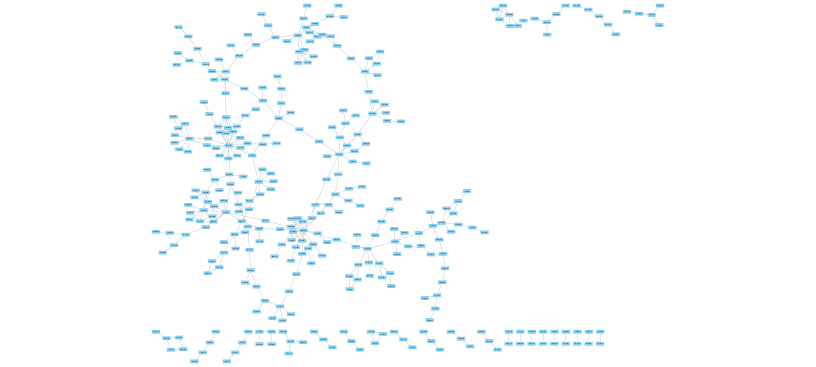

In [3]:
p4c.export_image(filename="galFiltered.png")
from IPython.display import Image
Image('galFiltered.png')

In [ ]:
task_ids_file = "../Manufactured case/Gnps task ids.json"
with open(task_ids_file) as task_ids_data:
    task_ids = json.load(task_ids_data)

task_id = task_ids[0]
all_annotations = GnpsCacher.cache_retrieve(task_id)
parameters = GnpsCacher.cache_retrieve_parameters(task_id)
isc = GnpsInchiScore(all_annotations, parameters)
new_cols = {
    f"inchi_gnps_{isc.min_peaks}_{isc.max_delta_mass}": isc.inchis,
    f"score_gnps_{isc.min_peaks}_{isc.max_delta_mass}": isc.scores,
}


In [ ]:
isc.inchis

Id
1        
2     N/A
3        
4        
5        
6        
7        
8        
9        
10       
11       
12       
13       
14       
15       
16       
17       
18       
19       
20       
21       
22       
23       
24    N/A
25       
26       
27       
28    N/A
29       
30       
31       
32       
33       
34       
35       
36       
37       
39       
40       
41       
42       
43       
44       
45       
46       
47       
48       
49       
50       
51       
52       
53       
54       
55       
56       
57       
58       
59       
60       
61       
62       
63       
64       
65       
66       
67       
68       
70       
71    N/A
72       
73       
74       
75       
76       
77       
78       
79       
80       
81       
82       
83       
84       
85       
86       
87       
88       
89       
90       
92       
93       
94       
95       
96       
Name: INCHI, dtype: object